In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

In [2]:
df = pd.read_parquet("cmm_erdos_bootcamp_2020_timeseries.pq", engine='pyarrow')
df.date_val = pd.to_datetime(df.date_val)

In [3]:
display(df.head())
display(df.tail())

,date_val,calendar_year,calendar_month,calendar_day,day_of_week,is_weekday,is_workday,is_holiday,volume_A,volume_B,volume_C
0,2017-01-01,2017,1,1,1,0,0,1,974,701,574
1,2017-01-02,2017,1,2,2,1,0,0,5073,2976,3149
2,2017-01-03,2017,1,3,3,1,1,0,6710,4249,3595
3,2017-01-04,2017,1,4,4,1,1,0,5746,3942,3651
4,2017-01-05,2017,1,5,5,1,1,0,5863,4279,3792


,date_val,calendar_year,calendar_month,calendar_day,day_of_week,is_weekday,is_workday,is_holiday,volume_A,volume_B,volume_C
1090,2019-12-27,2019,12,27,6,1,1,0,8362,3650,3661
1091,2019-12-28,2019,12,28,7,0,0,0,2906,1298,1232
1092,2019-12-29,2019,12,29,1,0,0,0,3024,1357,1349
1093,2019-12-30,2019,12,30,2,1,1,0,7444,3690,3690
1094,2019-12-31,2019,12,31,3,1,1,0,8324,3971,4062


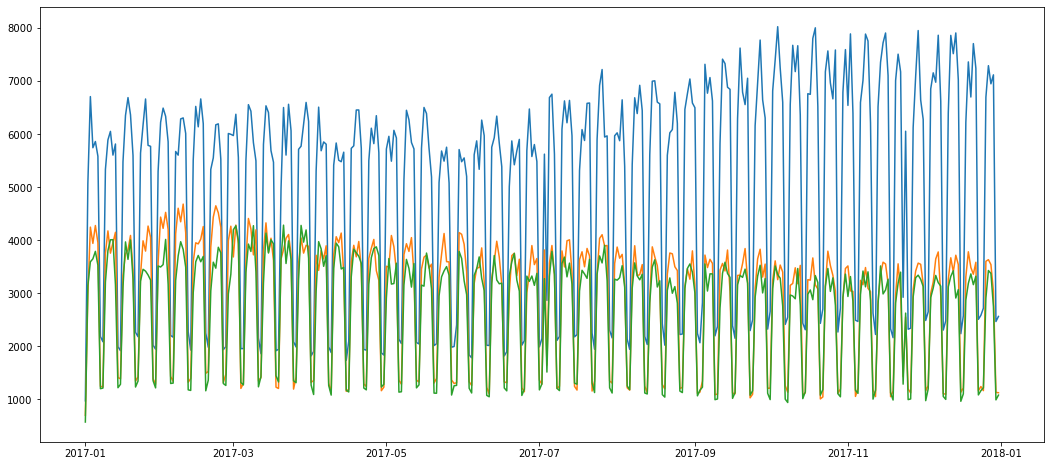

In [4]:
df2017 = df.loc[df.date_val < datetime(2018, 1, 1)]

a_vals = df2017.volume_A.values.ravel()
b_vals = df2017.volume_B.values.ravel()
c_vals = df2017.volume_C.values.ravel()

fig, ax = plt.subplots(figsize=(18, 8))
ax.plot(df2017.date_val, a_vals)
ax.plot(df2017.date_val, b_vals)
ax.plot(df2017.date_val, c_vals)

plt.show()

In [5]:
# Train on 2017 & 2018, test on 2019
train_test_sep = datetime(2019, 1, 1)
df_train = df.loc[df.date_val < train_test_sep]
df_test = df.loc[df.date_val >= train_test_sep]

In [6]:
display(df_train.tail())
display(df_test.head())

,date_val,calendar_year,calendar_month,calendar_day,day_of_week,is_weekday,is_workday,is_holiday,volume_A,volume_B,volume_C
725,2018-12-27,2018,12,27,5,1,1,0,8206,3915,3971
726,2018-12-28,2018,12,28,6,1,1,0,7708,4233,3333
727,2018-12-29,2018,12,29,7,0,0,0,2968,1482,1229
728,2018-12-30,2018,12,30,1,0,0,0,2654,1453,1173
729,2018-12-31,2018,12,31,2,1,1,0,8401,3674,3411


,date_val,calendar_year,calendar_month,calendar_day,day_of_week,is_weekday,is_workday,is_holiday,volume_A,volume_B,volume_C
730,2019-01-01,2019,1,1,3,1,0,1,4194,1750,1959
731,2019-01-02,2019,1,2,4,1,1,0,10340,4682,3903
732,2019-01-03,2019,1,3,5,1,1,0,10062,4008,4314
733,2019-01-04,2019,1,4,6,1,1,0,9014,4550,4075
734,2019-01-05,2019,1,5,7,0,0,0,3259,1451,1327


In [11]:
# naive sesonal method for benchmarking    (This isn't working yet)
def seas_naive(day, period=7):
    delta_index =  df_test.loc[df_test.date_val == day].index - df_test.index[0]
    index = df_train.index[-1] - period + delta_index%period
    return df_train.iloc[index]

In [12]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

train_A, train_B, train_C = df_train.volume_A.values, df_train.volume_B.values, df_train.volume_C.values
test_A, test_B, test_C = df_test.volume_A.values, df_test.volume_B.values, df_test.volume_C.values

modelA = SARIMAX(train_A, order=(2, 1, 2), seasonal_order=(2, 0, 2, 7))
fitA = modelA.fit(disp=False)

/home/mohammed/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/mohammed/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [13]:
modelB = SARIMAX(train_B, order=(1, 1, 1), seasonal_order=(1, 0, 1, 7))
fitB = modelB.fit(disp=False)

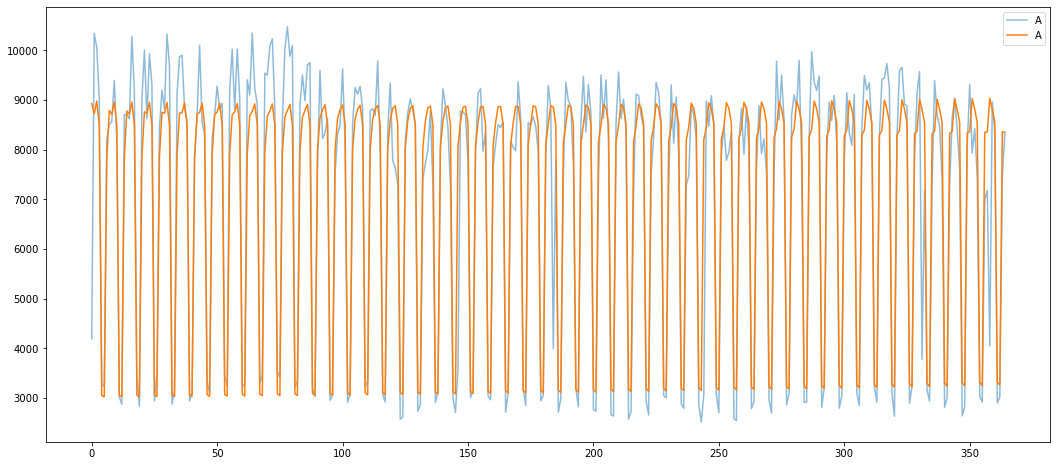

In [14]:
yhatA = fitA.forecast(len(test_A))
yhatB = fitB.forecast(len(test_B))

fig, ax = plt.subplots(figsize=(18, 8))
plt.plot(test_A , label='A', alpha=.5)
plt.plot(yhatA , label='A')

#plt.plot((test_B - yhatB), label='B')
plt.legend()

plt.show()

In [15]:
df_test[((test_A - yhatA) / test_A) < -1]

,date_val,calendar_year,calendar_month,calendar_day,day_of_week,is_weekday,is_workday,is_holiday,volume_A,volume_B,volume_C
730,2019-01-01,2019,1,1,3,1,0,1,4194,1750,1959
876,2019-05-27,2019,5,27,2,1,0,1,3593,1469,1775
914,2019-07-04,2019,7,4,5,1,0,1,3994,1563,1633
974,2019-09-02,2019,9,2,2,1,0,1,3068,1573,1438
1061,2019-11-28,2019,11,28,5,1,0,1,3780,1760,1509
1088,2019-12-25,2019,12,25,4,1,0,1,4050,1606,1546


In [16]:
np.abs((test_A - yhatA) / test_A).mean()

0.09394601793302088

In [17]:
np.abs((test_B - yhatB) / test_B).mean()

0.11542423273122278